# Tutorial 2 - Quantum phase estimation

Quantum Phase Estimation (QPE) is of particular importance as a subroutine of Shor's algorithm, which is one of the few quantum algorithms with the potential for exponential speed up.
It's main purpose is to extract phases applied by given quantum gates $U$.
This can be reused as an eigenvalue problem solver, which makes it useful for various mathematical, mechanical and chemical problems.

This tutorial will cover the individual components of QPE and conclude with an eigenvalue calculation for an $H_2$ molecule.
This will help the reader gain a better understanding of the hurdles that one has to overcome to fully utilize the potential of QPE.

## 2.1 Amplitude encoding / State preparation

Whenever we want to do linear algebra on quantum devices we need a way to encode vectors in quantum states.
A common method is the so called amplitude encoding in which the single vector entries are stored in the amplitudes of the single quantum states in a superposition.

\begin{equation*}
    \bm{a}
    =
    \begin{pmatrix}
        a_0\\
        \vdots\\
        a_{N-1}
    \end{pmatrix}
    =
    \sum_{i=0}^{N-1}
        a_i \hat{e}_i
    \xrightarrow{\text{encoding}}
    \sum_{i=0}^{N-1}
        a_i \ket{i}
    =
    \ket{\psi_a}
\end{equation*}





### Grover-Rudolph method
We have learned in the last tutorial that we can alter the amplitudes in a quantum state by using rotation around the $y$-axis ($R_y(\vartheta)$).
\begin{equation*}
    R_y(2\vartheta)\ket{0}
    =
    \cos(\vartheta)\ket{0}
    +\sin(\vartheta)\ket{1}
\end{equation*}
And in a similar way we can use a series of those rotations to prepare an arbitrary $n$-qubit states.
We will illustrate this for an two-qubit system.
At first, we map the amplitudes to a series of rotations
\begin{equation*}
    \begin{pmatrix}
        a_0\\
        a_1\\
        a_2\\
        a_3
    \end{pmatrix}
    =
    \begin{pmatrix}
        \cos\vartheta_0\cos\vartheta_{01}\\
        \cos\vartheta_0 \sin\vartheta_{01}\\
        \sin\vartheta_0\cos\vartheta_{11}\\
        \sin\vartheta_0\sin\vartheta_{11}
    \end{pmatrix},
\end{equation*}
where the first rotation angle $\vartheta_0$ corresponds to a $y$-rotation of the most significant qubit and the secondary angles ($\vartheta_{01}$, $\vartheta_{11}$ ) to rotations of the less significant qubit.
In there, the secondary rotation angles depend on the state of the most significant qubit.
This means we need to apply those rotations in order from most significant to least significant qubit and control them with the more significant qubits.

### Example
Lets assume we want to prepare the state 
\begin{equation*}
    \ket{\psi_0}
    =
    \left(
        - \frac{3}{\sqrt{20}},
         \frac{3}{\sqrt{20}},
         \frac{1}{\sqrt{20}},
        - \frac{1}{\sqrt{20}}
    \right)^T,
\end{equation*}
using the Grover-Rudolph method.
We start by mapping the amplitudes $a_0,\dots,a_3$ to the angles $\vartheta_0,\vartheta_{01},\vartheta_{11}$.
This is just some trigonometry.

In [2]:
import numpy as np

# Enter the state as array
target_state = [
    -3/np.sqrt(20),
    3/np.sqrt(20),
    1/np.sqrt(20),
    -1/np.sqrt(20)
]

# compute the angles with numpy
theta_0 = np.arccos(np.sqrt(target_state[0]**2+target_state[1]**2))
theta_01 = np.arctan2(target_state[1], target_state[0])
theta_11 = np.arctan2(target_state[3], target_state[2])

# Return the angles
print('theta_0  = {0: 5.3f}'.format(theta_0))
print('theta_01 = {0: 5.3f}'.format(theta_01))
print('theta_11 = {0: 5.3f}'.format(theta_11))


theta_0  =  0.322
theta_01 =  2.356
theta_11 = -0.785


Now we gonna use those angles to rotate the quantum state of two qubits into the correct position.

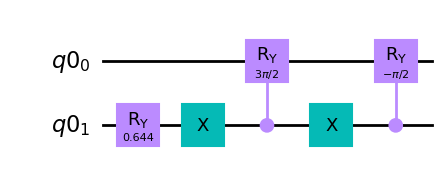

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Initialize registers and the circuit
state_register = QuantumRegister(2)
circ_1 = QuantumCircuit(state_register)

# We start by rotating the most significant qubit
circ_1.ry(2*theta_0 ,state_register[1])

# Followed by the rotation of the two subspaces,
# generated by the previous rotation.
# At first we rotate the second qubit if the first is in the state |0>
circ_1.x(state_register[1])
circ_1.cry(2*(theta_01), state_register[1], state_register[0])
circ_1.x(state_register[1])

# At last we rotate the second qubit if the first is in the state |1>
circ_1.cry(2*(theta_11), state_register[1], state_register[0])

# Draw the circuit
circ_1.draw('mpl')

In [4]:
def print_state(state):
    for amp in np.array(state):
        print('|{0: 5.3f}|'.format(amp))

At last we will need to run this circuit and extract the state we just prepared to see if we succeeded.

In [5]:
from qiskit import Aer, execute

# Define the backend we use. In this case the 'statevector_simulator'
backend = Aer.get_backend('statevector_simulator')
# Execute the circuit and extract the state vector
state_0 = execute(circ_1, backend).result().get_statevector()

print("My own state")
print_state(state_0)
print()
print("The target state")
print_state(target_state)

My own state
|-0.671+0.000j|
| 0.671+0.000j|
| 0.224+0.000j|
|-0.224+0.000j|

The target state
|-0.671|
| 0.671|
| 0.224|
|-0.224|


### Task 2.1a
Prepare other states by changing the code above

### Initialize method

Now we want to do the same with the `initialize(vector, quantum_register)` method provided by qiskit, which can be applied directly to you circuit.

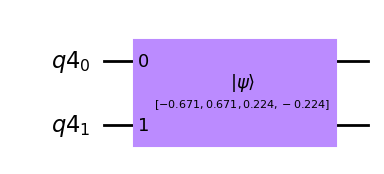

In [6]:
state_register = QuantumRegister(2)
circ_1 = QuantumCircuit(state_register)

# apply the initialize() methode
circ_1.initialize(target_state, state_register)

circ_1.draw('mpl')

The method `decompose()` tells you what the blackbox `initialize()` is doing.
You can even apply decompose multiple times to go deeper and deeper towards elementry quantum gates.
Apply `decompose()` multiple times to you circuit and draw the result

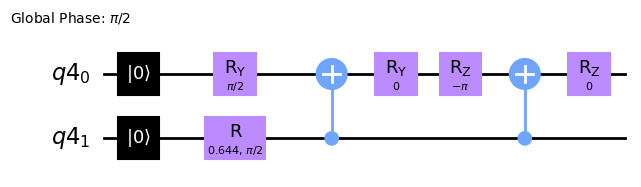

In [7]:
# Apply decompose() to your circuit to see what hides behind the initialize() blackbox
depth = 5
circ_1_dec  = circ_1
for _ in range(depth):
    circ_1_dec  = circ_1_dec.decompose()

circ_1_dec.draw('mpl')

In [8]:
state_1 = execute(circ_1, backend).result().get_statevector()
print("The initialized state")
print_state(state_1)
print()

print('the target state')
target_state = [-3/np.sqrt(20), 3/np.sqrt(20), 1/np.sqrt(20), -1/np.sqrt(20)]
print_state(target_state)

The initialized state
|-0.671+0.000j|
| 0.671+0.000j|
| 0.224+0.000j|
|-0.224+0.000j|

the target state
|-0.671|
| 0.671|
| 0.224|
|-0.224|


### Task 2.1b

Try different decomposition depths.

### Task 2.1c

Try `initalize()` and `decompose()` with other states and more qubits.

## 2.2 Time evolution / Hamiltonian simulation

The second module necessary for Quantum phase estimation is the so called Hamiltonian simulation.
This is the implementation of the time evolution operator as quantum gate
\begin{equation*}
    U
    =
    e^{iHt},
\end{equation*}
where $t$ is the evolution time and $H$ the Hamiltonian and we set $\hbar=1$.
For the use in the quantum phase estimation we need a Hamiltonian which is equal to the matrix in our eigenvalue problem.

The implementation of last comes with two problems.
The first of which is the realization of an exponential function.
There is no natural way of doing this for arbitrary Hamiltonian $H$.
The second problem is the implementation of $H$ as a quantum gate.

For the use in the QPE we will actually need a controlled Hamiltonian simulation, which applies the time evolution only to a target qubit or quantum register if a certain control qubit is in the state $\ket{1}$.
This will become clearer when we decribe the full QPE algorithm

Those problems are common obstacles on the pursuit of quantum speed up. 
Hence, we will not try to teach you the most advanced methods in here as they are quite involved.
Instead, we will give you the possibility to play with the qiskit method `UnitaryGate(matrix)` and `append(unitary, register)` which allows you to realize any matrix as quantum gate.



### Example

Generate the $y$-Pauli matrix as numpy array

In [9]:
# generate the y-Pauli matrix
h_mat =  np.array([[0,-1j],[1j,0]])
print(h_mat)

[[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]]


In [10]:
from qiskit.extensions import UnitaryGate
from scipy import linalg


def c_time_evolution(h_mat, time):
    size = len(h_mat)
    c_u = UnitaryGate(np.vstack([np.hstack([np.eye(size),
                                            np.zeros((size, size))]),
                                 np.hstack([np.zeros((size, size)),
                                            linalg.expm((1j) * h_mat * time)])]),
                                            label='$e^{iHt}$')
    return c_u

We have given you a function, which generates a controlled version of the unitary gate $U=e^{iHt}$.
This can be described in matrix form as
\begin{equation*}
    cU 
    =
    \begin{pmatrix}
    1_{n\times n}& 0\\
    0& e^{iHt}
    \end{pmatrix},
\end{equation*}
where $1_{n\times n}$ is the identity and $n$ is the size of the matrix $H$.
This operation acts on two qubits simultaneously.
A control qubit and a target qubit.
The gate reads the information stored in the control qubit and applies $U$ only to the target qubit if the information in the control qubit is 1.

We will use the $y$-Pauli matrix and the controlled time evolution to simulate the $y$-rotation
$$
    R_y(\theta)
    =
    e^{-i\frac{\vartheta}{2}\sigma_y},
$$
for the angle $\vartheta = \pi/2$.

Note: This corresponds to a spin-particle within a magnetic field directed in the y-direction.
However, this is just a physical interpretation of this specific time evolution.
The Hamiltonian simulation can realize this on any quantum platform independent of physical spins.

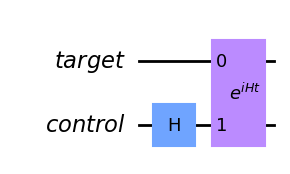

In [11]:
# Initalize the registers and the circuit
control = QuantumRegister(1, 'control')
target = QuantumRegister(1, 'target')
circ_2 = QuantumCircuit(target, control)

theta = np.pi/2
# Apply an Hadamard gate to test both possible states at once
circ_2.h(control)

# Apply controlled time evolution operator to the circuit
c_u = c_time_evolution(h_mat, -theta/2)
circ_2.append(c_u, [target, control])

circ_2.draw('mpl')

Note: We can check both possible control states ($\ket{0},\ket{1}$) at once in here as the matrix for $cU$ is diagonal.
We do this in quantum computing by using superpositions which we generate with Hadamard gates (cf. the Hadamard gate on the control qubit).
The first two entries of the resulting state vector will contain the unchanged target state and the last two the state after the time evolutions.
Keep in mind that the Hadamard gate adds an overall factor of $1/\sqrt{2}$

In [12]:
state_2 = execute(circ_2, backend).result().get_statevector()
print_state(state_2)

| 0.707+0.000j|
| 0.000+0.000j|
| 0.500+0.000j|
| 0.500+0.000j|


We expect to have no rotation if the control qubit is in the state $\ket{0}$ as suppresses the operation and we expect an equal split if it is $\ket{1}$.
Hence, 
$$
\ket{\Psi} 
=
 \left(\frac{1}{\sqrt{2}}, 0,\frac{1}{2}, \frac{1}{2}\right)^T
 $$

### Task 2.2a

Test what happens if you replace the Hamiltonian `h_mat` with other matrices.

## 2.3 Quantum Fourier transform

The last module necessary for quantum phase estimation is the quantum Fourier transform (QFT) which is similar to the discrete Fourier transform. 
Given a vector of $N$ complex numbers $(x_0, ..., x_{N-1})$, its discrete Fourier transform is given by another vector of $N$ complex numbers $(y_0, ..., y_{N-1})$,
\begin{equation}
    y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1} x_j\omega_N^{jk}
\end{equation}
where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.
Similarly, the quantum Fourier transform acts on a quantum state $\sum_{j=0}^{N-1} x_j \vert j \rangle$ (where $\ket{j}$ is an $(\log_2N)$-qubit register) and maps it to the quantum state $\sum_{k=0}^{N-1} y_k \vert k \rangle$ according to the formula (1).
Note that only the amplitudes of the state are affected by this transformation.

This can also be expressed as the map:
$$\vert j \rangle \mapsto \vert y \rangle = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\omega_N^{jk} \vert k \rangle$$

Or the unitary matrix:
$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle \langle j \vert$$

The inverse Quantum Fourier Transform acts similarly but rotating in opposite direction, so the amplitudes are given by
$$
x_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1} y_j\omega_N^{-jk}.
$$

One may notice that the QFT is moving the information stored in the state $\ket{j}$ in to the exponent or phase of the new quantum state.
We will use this later in the quantum phase estimation (QPE) in reverse to transfer the information about the phase into the state.

The QFT can be realized by a series of Hadamard gates and $z$-rotations as described in the following function.
To be precise we describe both, the QFT and its inverse, in the following as the inverse is necessary for the QPE.

In [13]:
def swap_register(circuit, register):
    for qubit_a, qubit_b in zip(register[:len(register)//2], register[-1:len(register)//2-1:-1]):
        circuit.swap(qubit_a, qubit_b)


def qft(circuit, register):
    for idx_main, main_qubit in reversed(list(enumerate(register))):
        circuit.h(main_qubit)
        for idx_control, control_qubit in reversed(list(enumerate(register[:idx_main]))):
            circuit.crz(np.pi/2**(idx_main - idx_control),
                       control_qubit, main_qubit)
    swap_register(circuit, register)


def qft_dagger(circuit, register):
    swap_register(circuit, register)
    for idx_main, main_qubit in enumerate(register):
        for idx_control, control_qubit in enumerate(register[:idx_main]):
            circuit.crz(-np.pi/2**(idx_main - idx_control),
                        control_qubit, main_qubit)
        circuit.h(main_qubit)


We are not giving you the full proof as this involves a lot of math and some time we don't have.
The interested reader can simply follow the proof on wikipedia ([https://en.wikipedia.org/wiki/Quantum_Fourier_transform](https://en.wikipedia.org/wiki/Quantum_Fourier_transform)).
But we have prepared a little showcase in the following where we prepare a delta like function (or just one state $\ket{3}$) and Fourier transform it.

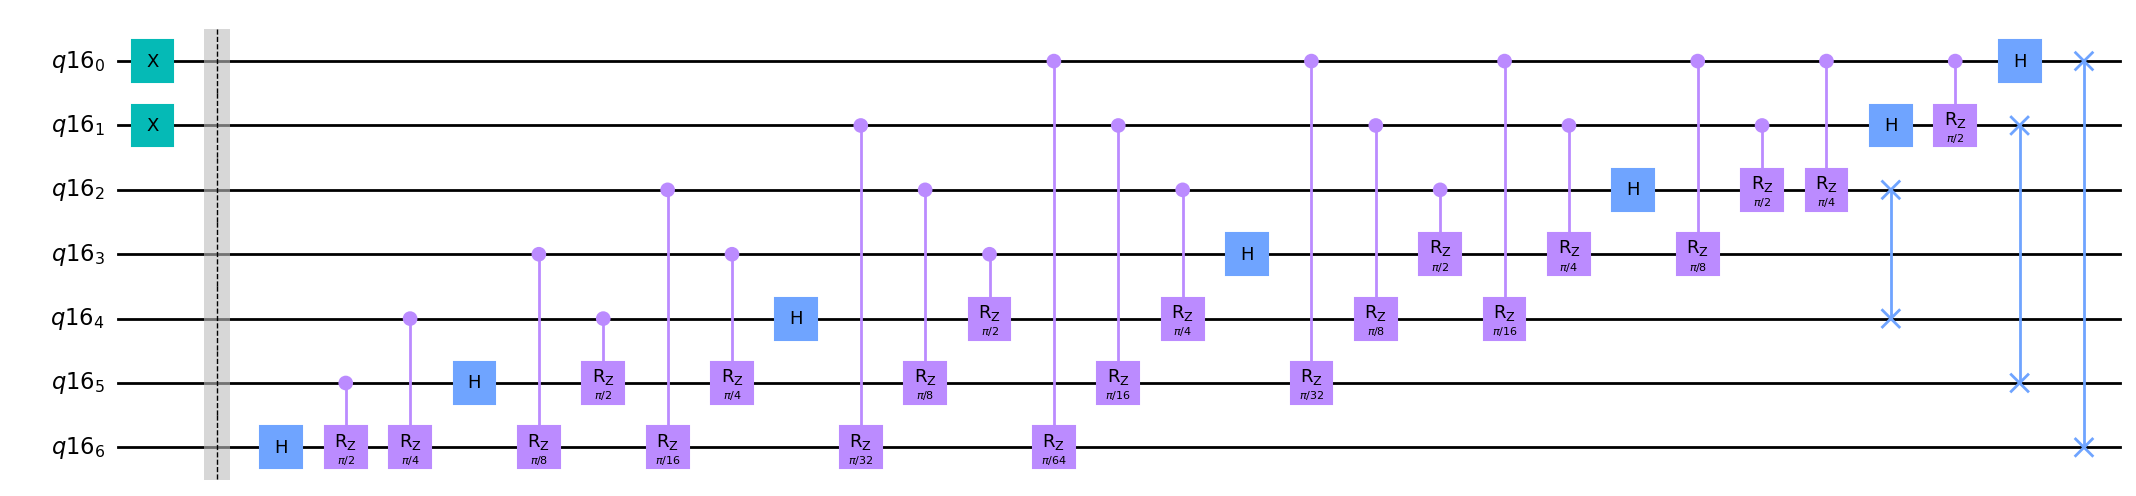

In [14]:
num_qb = 7

qr = QuantumRegister(num_qb)
circ_qft = QuantumCircuit(qr)

# Preapre state |2>
circ_qft.x([0,1])
circ_qft.barrier()

# Quantum Fourier transform (QFT)
qft(circ_qft, qr)

circ_qft.draw('mpl', fold=-1)

In [15]:
# Execute the circuit and extract the state vector
state_qft = execute(circ_qft, backend).result().get_statevector()

After this we plot the real and imaginary part of the extracted statevector coefficients, which should be the cosine and sine, respectively, with frequency $2\pi3/2^n$.

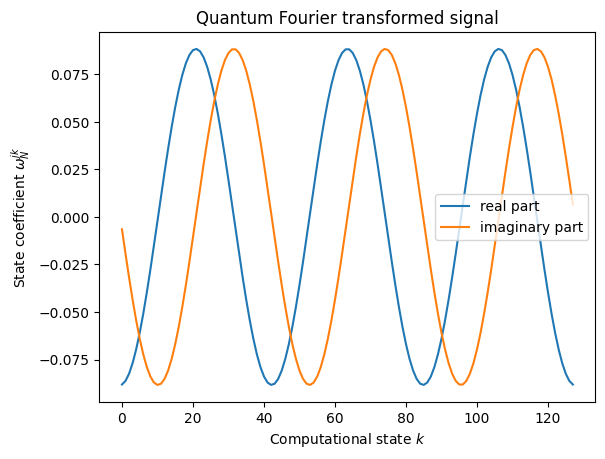

In [31]:
import matplotlib.pyplot as plt

x = [i for  i  in range(2**num_qb)]
y = np.real(state_qft)
z = np.imag(state_qft)

plt.plot(x, y, label='real part')
plt.plot(x,z, label='imaginary part')
plt.title('Quantum Fourier transformed signal')
plt.xlabel('Computational state $k$')
plt.ylabel('State coefficient $\omega^{jk}_N$')
plt.legend()
plt.show()

#### Task 2.3a

Try to prepare different states by moving the position of the NOT/X gates. What is happening?

#### Task 2.3b
Try superpositions of multiple states by using the Hadamard gate.

## 2.4 Quantum phase estimation

The quantum phase estimation uses the fact that we describe quantum systems with linear algebra.
We can turn this around and use quantum systems to compute linear algebra problems.
For this, we use quantum states $\ket{\psi}$ to describe vectors $\bm{v}$ and quantum operations $U$ to describe matrices $H$.
\begin{equation}
    U\ket{\psi}
    \Leftrightarrow
    H \bm{v}.
\end{equation}
Typical mathematical operation like the multiplication of an matrix with an vector become as simple as applying one quantum operation.
Hence, quantum computer are natural solver for eigenvalue problems like
\begin{equation}
    H \bm{v}
    =
    \lambda \bm{v},
\end{equation}
where $\lambda$ is the eigenvalue of $H$ for $\bm{v}$.
The tricky part is that we can not replace any matrix $H$ with a quantum gate as they have to be unitary ($U^{-1} = U^\dagger$).
Thats why solve the following equation instead
\begin{equation}
    e^{2\pi iH} \bm{v}
    =
    e^{2\pi i\lambda} \bm{v}.
\end{equation}
which can be realized as unitary gate $U$ as long as $H$ is hermitian ($H = H^{\dagger}$).
The eigenvalue is no longer stored in the amplitude but in the phase of coefficient.

### The algorithm

<!-- Use this for VS code -->
<img src="imgs/qpe_circ.png" alt="drawing" width="600"/>

<!-- Use this line for general markdown -->
<!-- ![alt text](imgs/qpe_circ.png) -->

The method described in the previous paragraph is realized as follows in the QPE.
At first we encode the eigenstate $\bm{v}$ in the state $\ket{v}$.
Then we prepare all possible values for the phase $k$ in a secondary register by applying a series of Hadamard gates.
\begin{equation}
    \ket{0}\ket{v}
    \\
    \xrightarrow{H^{\otimes m}}
    \frac{1}{2^m}\sum_{k=0}^{2^m-1}\ket{k}\ket{v}.
\end{equation}
The reason for this will be more clear after we applied the inverse QFT in two steps.
But first, we apply a series of controlled unitaries $cU^t=e^{2\pi i H t c}$, where $c\in \{0,1\}$ is the state of the control qubit, and have
\begin{equation}
    \xrightarrow{cU^l}
    \frac{1}{2^m}\sum_{k=0}^{2^m-1}e^{2\pi i \lambda k}\ket{k}\ket{v},
\end{equation}
from which one can extract the phase with the inverse QFT and store it as binary number in the secondary register
\begin{equation}
    \xrightarrow{\text{QFT}^\dagger}
    \frac{1}{2^m}\sum_{k,x=0}^{2^m-1}e^{2\pi i (\lambda-2^{-m}x) k}\ket{x}\ket{v}
    \\
    =
    \ket{2^m\lambda}\ket{v},
\end{equation}
where we used that the amplitude becomes 1 if the argument in the exponent vanishes.
This is the case for $x=2^m\lambda$.
If one of the amplitudes is one, all the other are zero as the state vectors are normalized ($\sum_i a_i^2 = 1$).
Hence, we can simply measure the secondary register in the $z$-basis after one iteration of the QPE and have a multiple of the eigenvlaue $\lambda$ encoded as binary number.

For most Problems, we will not be able to represent $2^m\lambda$ as integer ($x$ is limited to integer number) which reduces the outcome to the closest integer and makes the corresponding amplitude slightly smaller than 1 and additional quantum states with small amplitude will remain.
This yields in a finite probability to achieve a wrong result after measuring and decoding the binary number.
However, we can measure multiple times and concentrate on the most common outcome to achieve the closest result.

### $H_2$ Problem

To map a fermionic system to qubits we start with the Hamiltonian of our chemical system in second quantization which reads 

$$H_F = \sum_{ij} t_{ij} a_i^\dagger a_i  + \sum_{ijkl} u_{ijkl} a_i^\dagger a_k^\dagger a_l a_j$$

Here $a_i^\dagger$ and $a_i$ are the electronic creation and annihlation operatos for the i-th orbital. The parameters $t_{ij}$ and $u_{ijkl}$ describe the one- and two-electron interactions and are computed classically as the overlap integrals of the orbitals in the respective basis.

In the case of $H_2$ the parameters can be computed by evaluating
$$t_{ij} =  \int d\bf{x_1} \Phi_i(\bf{r_1}) \left( -\frac{\nabla_1^2}{2} + \sum_{n=1}^2 \frac{Z_n}{|\bf{r_1} - R_n|} \right) \Phi_j(\bf{x_1})$$
and
$$u_{ijkl} = \int \int d\bf{r_1} d\bf{r_2} \Phi_i^*(\bf{r_1}) \Phi_j(\bf{r_1}) \frac{1}{|\bf{r_1} -\bf{r_2}|} \Phi_k^*(\bf{r_2})\Phi_l(\bf{r_2})$$
where $Z_n$ are the nuclei charges and each wavefunction $\Phi_i(x_1)$ orbital is a 1s orbital centered at the respective hydrogen atom.

We now use the Bravyi-Kitaev transformation and rewrite the annilation and creation operators as
$$a_j^\dagger \equiv X_{U(j)} \otimes \hat{\sigma^+}_j \otimes Z_{P(j)} = \frac{1}{2}(X_{U(j)} \otimes X_j \otimes Z_{P(j)} - iX_{U(j)} \otimes Y_j \otimes Z_{P(j)})$$

$$a_j \equiv X_{U(j)} \otimes \hat{\sigma^-}_j \otimes Z_{P(j)} = \frac{1}{2}(X_{U(j)} \otimes X_j \otimes Z_{P(j)} + iX_{U(j)} \otimes Y_j \otimes Z_{P(j)})$$

for all j even and 
$$a_j^\dagger \equiv X_{U(j)} \otimes \hat{\Pi^+}_j \otimes Z_{R(j)}$$
$$a_j^\dagger \equiv X_{U(j)} \otimes \hat{\Pi^-}_j \otimes Z_{R(j)}$$
where 
$$\Pi^{\pm} = \frac{1}{2} (X_j \otimes Z_{F(j)} \mp i Y_j)$$ 
and where P(j),U(j),F(j) are the parity, update and flip set and $R(j)=P(j) \backslash F(j)$ is the remainder set. 

With this we arrive at the following four qubit Hamiltonian  ($\otimes$ and identities on other qubits omitted.)
$$H = g_{0} \mathbf{1} + g_{1}Z_{0} + g_{2}Z_{1} + g_{3}Z_{2} + g_{1}Z_{0}Z_{1} + g_{4}Z_{0}Z_{2} + g_{5}Z_{1}Z_{3} + g_{6}X_{0}Z_{1}X_{2} + g_{6}Y_{0}Z_{1}Y_{2} + \\ g_{7}Z_{0}Z_{1}Z_{2} + g_{4}Z_{0}Z_{2}Z_{3} + g_{3}Z_{1}Z_{2}Z_{3} + g_{6}X_{0}Z_{1}X_{2}Z_{3} + g_{6}Y_{0}Z_{1}Y_{2}Z_{3} + g_{7}Z_{0}Z_{1}Z_{2}Z_{3}$$

We see that only two of the qubits have none diagonal components, meaning we can rewrite the above expression into a two qubit Hamiltonian of the form
\begin{equation}
    H_{H_2}
    =
    f_0 \mathbb{1}\otimes \mathbb{1}
    +f_1 \sigma_z \otimes \sigma_z
    +f_2 \sigma_z \otimes \mathbb{1}
    +f_3 \mathbb{1}\otimes \sigma_z
    +f_4 \sigma_x \otimes \sigma_x,
\end{equation}

In the following we will use the QPE to compute the eigenvalues of an $H_2$ molecule.
with $f_0 = -1.0524$, $f_1 = -0.0113$, $f_2 = -0.3979$, $f_3 = 0.398$, $f_4 = 0.1809$ (for more details see [Moll et.al](https://www.researchgate.net/publication/320196037_Quantum_optimization_using_variational_algorithms_on_near-term_quantum_devices)).
Hence we can construct a corresponding time evolution operator for the matrix $H_{H_2}$ and use it in the QPE.


### Classical eigenvalue solver

We start by computing the eigenvalues and eigenvectors of $H_{H_2}$ classically using `numpy.linalg.eig()`.

In [17]:
# Coefficients
f_0 = -1.0524
f_1 = -0.0113
f_2 = -0.3979
f_3 = 0.398
f_4 = 0.1809

# Define the four Pauli matrices as arrays
p_0 = [[1, 0], [0, 1]]
p_x = [[0, 1], [1, 0]]
p_y = [[0, -1j], [1j, 0]]
p_z = [[1, 0], [0, -1]]

# Generate the full hamiltonian
h_h2 = f_0 * np.kron(p_0, p_0)\
    + f_1 * np.kron(p_z, p_z)\
    + f_2 * np.kron(p_z, p_0)\
    + f_3 * np.kron(p_0, p_z)\
    + f_4 * np.kron(p_x, p_x)

# Use numpy.linalg.eig() to find the eigenvlaues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(h_h2)
eigenvectors = eigenvectors.transpose()

print('Matrix\n',h_h2)
print('Eigenvalues\n',eigenvalues)
print('Eigenvectors\n',eigenvectors)


Matrix
 [[-1.0636  0.      0.      0.1809]
 [ 0.     -1.837   0.1809  0.    ]
 [ 0.      0.1809 -0.2452  0.    ]
 [ 0.1809  0.      0.     -1.0638]]
Eigenvalues
 [-0.88279997 -1.24460003 -0.2249005  -1.8572995 ]
Eigenvectors
 [[ 0.7073022   0.          0.          0.70691131]
 [ 0.70691131  0.          0.         -0.7073022 ]
 [ 0.          0.11151402  0.99376286  0.        ]
 [ 0.         -0.99376286  0.11151402  0.        ]]


### QPE as quantum eigenvalue solver

We will now compute the eigenvalues using the full quantum phase estimation.
For this you need to implement the before learned modules (state preparation, hamiltonian simulation and quantum Fourier transform) in the following circuit.

We start by initialize one of the previously derived eigenvectors of $H_{H_2}$ with the `initialize()` method.

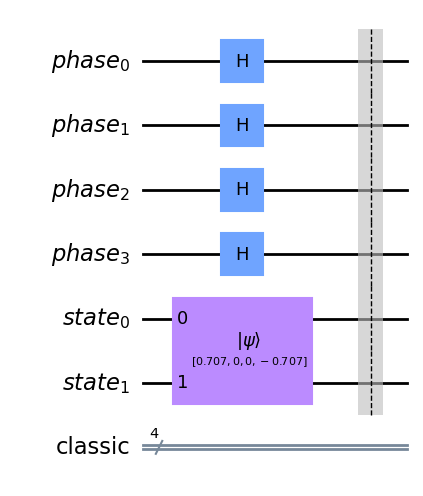

In [18]:
# Number of qubits in the phase register
accuracy = 4
# Number of qubits necessary for the state 
n = 2

#Initialize the registers and the circuit 
phase = QuantumRegister(accuracy, 'phase')
state = QuantumRegister(n, 'state')
creg = ClassicalRegister(accuracy, 'classic')
circ_qpe = QuantumCircuit(phase, state, creg)

# Prepare the first eigenvector
state_idx = 1
circ_qpe.initialize(eigenvectors[state_idx], state)

# Generate a superpositon of all states in the phase register
circ_qpe.h(phase)
circ_qpe.barrier()

# Draw the circuit
circ_qpe.draw('mpl', fold=-1)

Now we connect the secondary or phase register with the state register by applying the series of controlled time evolutions.
Compare with the image of the QPE for the exact order of the $cU^k$.
In general we wan to apply it once controlled by the least significant qubit in the phase register, $2^1$ times controlled by the second least significant qubit and $2^{l-1}$ times controlled by the $l$-th least significant qubit.
The significance of the qubits is given by the order we read the binary number in the phase register in the end.
We recommend to use the first or top qubit as least significant qubit as this order is used in the inverse QFT.

Note: The given time evolution method is only working for Hamiltonians with eigenvalues between 0 and 1 due to its circular symmetry. You have to renormalize the Hamiltonian with a suitable factor.

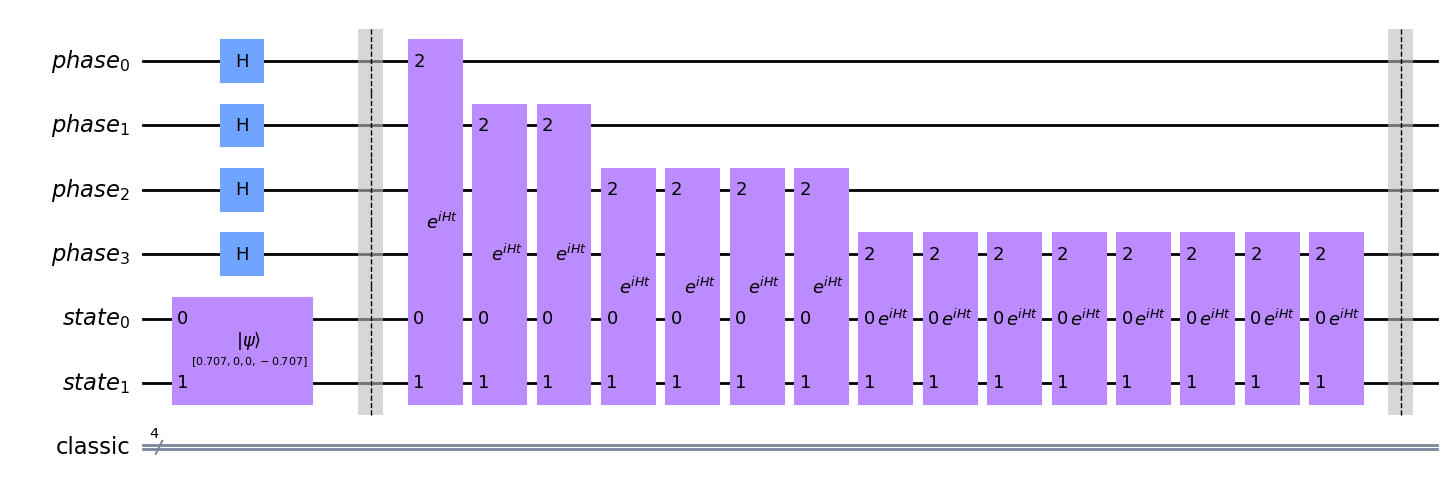

In [19]:

# Define a renormalization factor which brings the 
# desired eigenvalue between 0 and 1
renorm = -2

# Apply the series of controlled time evolutions 
# for H_H2/renorm and t=2*pi
c_u = c_time_evolution(h_h2/renorm, 2*np.pi)
for idx, control in enumerate(phase):
    for _ in range(2**idx):
        circ_qpe.append(c_u, [*state, control])
circ_qpe.barrier()

# Draw the circuit
circ_qpe.draw('mpl', fold=-1)


At last, apply the inverse QFT to the phase register.
For this, the order of the qubits is important again.
The given method interprets the first qubit as least significant.

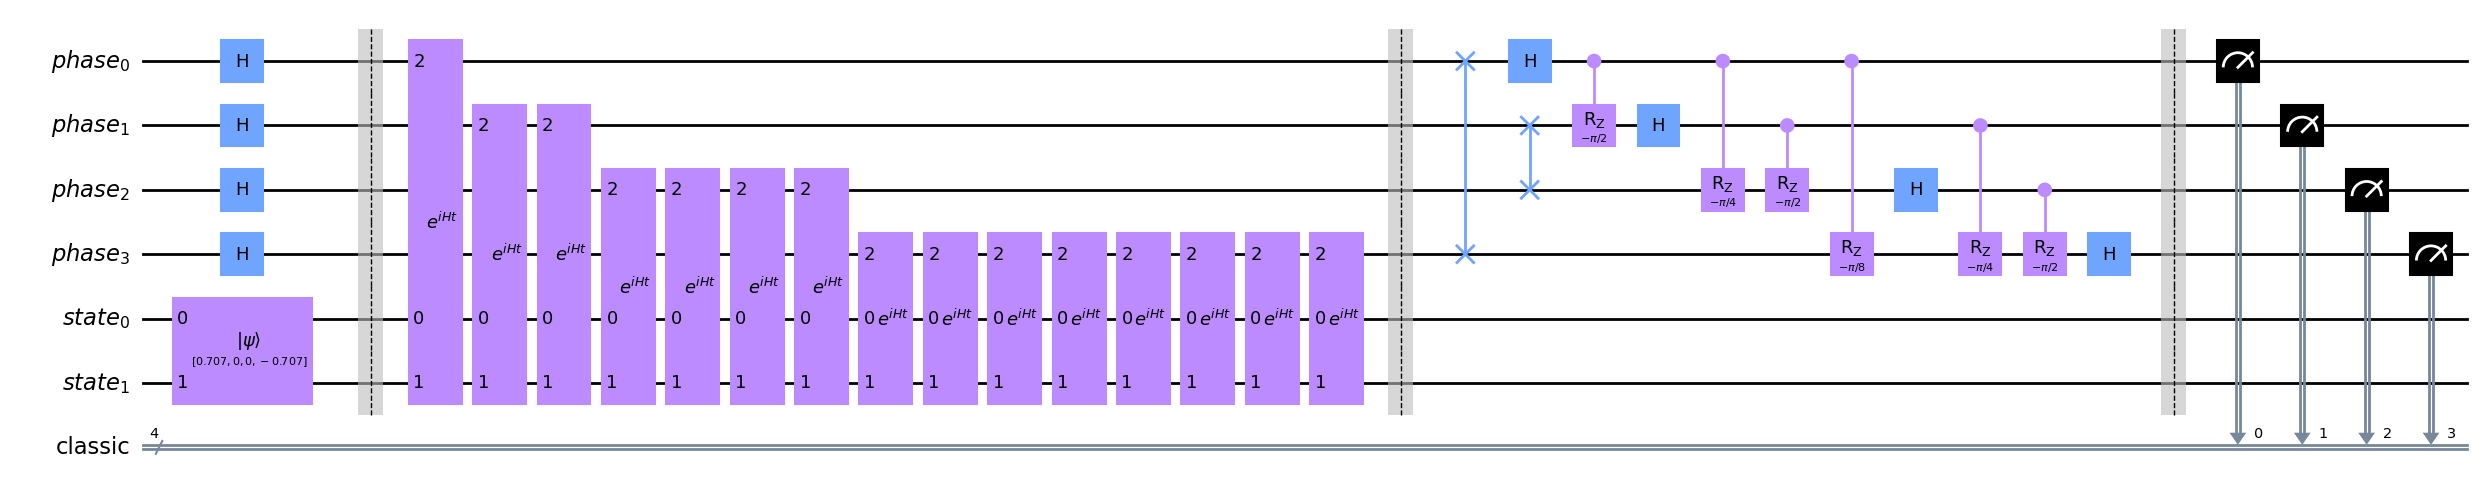

In [20]:
# apply the inverse qft
qft_dagger(circ_qpe, phase)
circ_qpe.barrier()

# Measure the phase and draw the ciruit
circ_qpe.measure(phase, creg)
circ_qpe.draw('mpl', fold=-1)

We can now simulate the circuit multiple times to find the phase with highest probability.

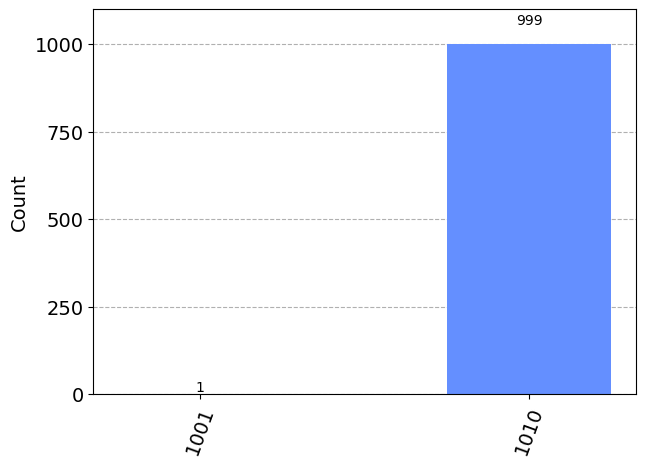

In [21]:
from qiskit.visualization import plot_histogram

# Define the backend
backend_aer = Aer.get_backend('aer_simulator')

#Run the circuit 1000 times
counts = execute(circ_qpe, backend_aer, shots=1000).result().get_counts()
plot_histogram(counts)


We have now prepared the QPE and measured the phase register 1000 times to achieve this histogram.
It tells you how often you measured a certain binary number.
As mentioned, in the description of the QPE, the binary number closest to $2^m\lambda$ is the one with the highest probability.
Extract the eigenvalue from the counts.

Note: Don't forget your renormalization of $H_{H_2}$

In [22]:
###
### Decode the binary result
### Hint: most_frequent() gets the peak of the histogramm
bin_peak = counts.most_frequent()
dec_peak = int(bin_peak,2)
est_eigval = renorm* dec_peak /2**accuracy

print('Estimated eigenvalue = {0: 5.3f}'.format(est_eigval))
print('Exact eigenvalue     = {0: 5.3f}'.format(eigenvalues[state_idx]))
###

Estimated eigenvalue = -1.250
Exact eigenvalue     = -1.245


The interested reader may have noticed that we used a classically derived eigenvector to prepare the corresponding eigenstate in the QPE.
But this is not necessary.
One could instead prepare a state which has a finite overlap with the desired eigenstate (this is easy to achieve as most random states share a finite overlap with any eigenstate) and measure over and over again.
Sooner or later we would find the desired eigenvalue and could further extract the exact eigenvector from the state register.
We won't want to go into detail here, but we wanted to add this for completeness.

### Task 2.4a

Exchange the eigenvector used in the initialization with one of the other three and test how the estimated eigenvalue is changing.

### Task 2.4b

Change the number of shots used in the circuit execution and see how this effects the result.

### Task 2.4c

Remove or exchange the renormalization and observe.

### Task 2.4d

Change the number of qubits in the phase register (accuracy) and see how this is affecting the estimated eigenvalue.